In [1]:
!python --version

Python 3.7.3


In [2]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

In [4]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:



In [5]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Set your root directory here
ROOT_DIR = "C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005"

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


In [7]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 4
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + numberPlate

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [9]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.9

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
#model_path = 'D:\MRCNN_python3.8\Maskrcnn_final\Safetyvest_hardhat_segmentation\part_2_tf2\logs\object20230216T1912\mask_rcnn_object_0300.h5'
model_path="C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\logs\\object20230927T2142\\mask_rcnn_object_0005.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Loading weights from  C:\Users\Maneka Wijesundara\Desktop\DLASS005\logs\object20230927T2142\mask_rcnn_object_0005.h5
Re-starting from epoch 5


In [10]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
      
        # Add classes. We have only one class to add.
        #self.add_class("object", 1, "Hard_hat")
        #self.add_class("object", 2, "Safety_vest")
        self.add_class("object", 1, "numberPlate")


     
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir,subset)
        print("dataset_dir:", dataset_dir)  # Check the dataset directory
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        #annotations1 = json.load(open('C:\\Users\\Maneka Wijesundara\\Desktop\\DLAss04\\Dataset\\train\\trainMe_json.json'))

        if subset == "train":
            annotations1 = json.load(open('C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\Dataset\\train\\trainMe6_json.json'))
        elif subset == "val":
            annotations1 = json.load(open('C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\Dataset\\val\\valMe6_json.json')) 
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
           # name_dict = {"Hard_hat": 1,"Safety_vest": 2}
            name_dict = {"numberPlate": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [11]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\Dataset", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\Dataset", "val")
dataset_val.prepare()

dataset_dir: C:\Users\Maneka Wijesundara\Desktop\DLASS005\Dataset\train
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
numids [1]
objects: ['numberPlate']
num

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  489.00000  max:  661.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


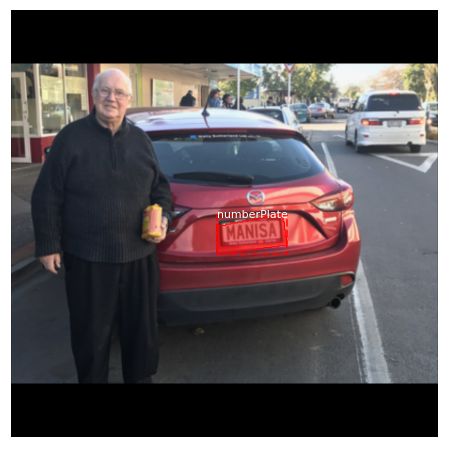

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (250, 400, 3)         min:    0.05490  max:    1.00000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90828  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



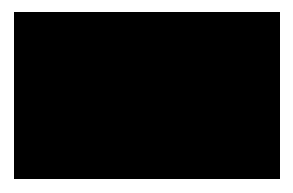

Processing 1 images
image                    shape: (450, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


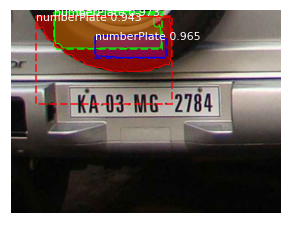

Processing 1 images
image                    shape: (232, 500, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



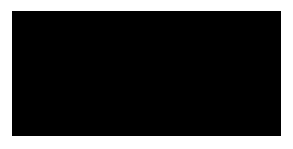

Processing 1 images
image                    shape: (300, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


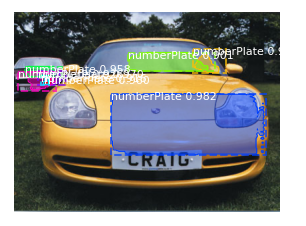

Processing 1 images
image                    shape: (450, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


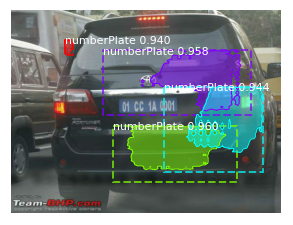

Processing 1 images
image                    shape: (225, 400, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



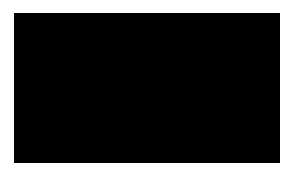

Processing 1 images
image                    shape: (400, 301, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



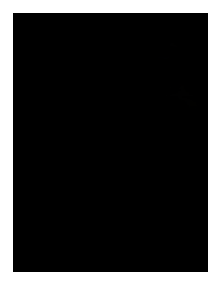

Processing 1 images
image                    shape: (225, 400, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



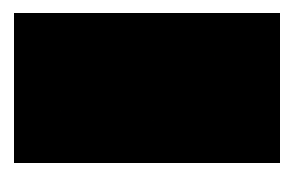

Processing 1 images
image                    shape: (192, 400, 3)         min:    0.00000  max:    0.87090  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -103.05986  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



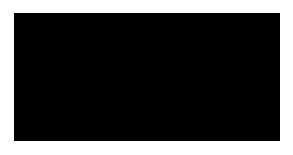

Processing 1 images
image                    shape: (300, 467, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


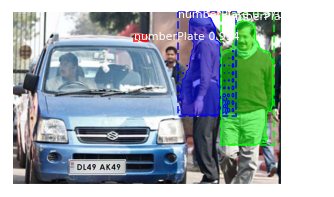

In [12]:
import skimage
import skimage.color
import skimage.io

real_test_dir = 'C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\test_images\\'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    # Convert the image to RGB if it has 4 channels (RGBA)
    if img.shape[-1] == 4:
        img = skimage.color.rgba2rgb(img)
    
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5, 5))



In [ ]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [13]:
# old numpy version was  1.19.5.


config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])

#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])

    #print("Predicted object : "+dataset.class_names[pred])
    # for j in range(len(dataset.class_names[gt])):
	    # print("Ground truth object : "+j)
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  4
the actual len of the pred vect is :  4
Average precision of this image :  0.0
The actual mean average precision for the whole images 0.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt

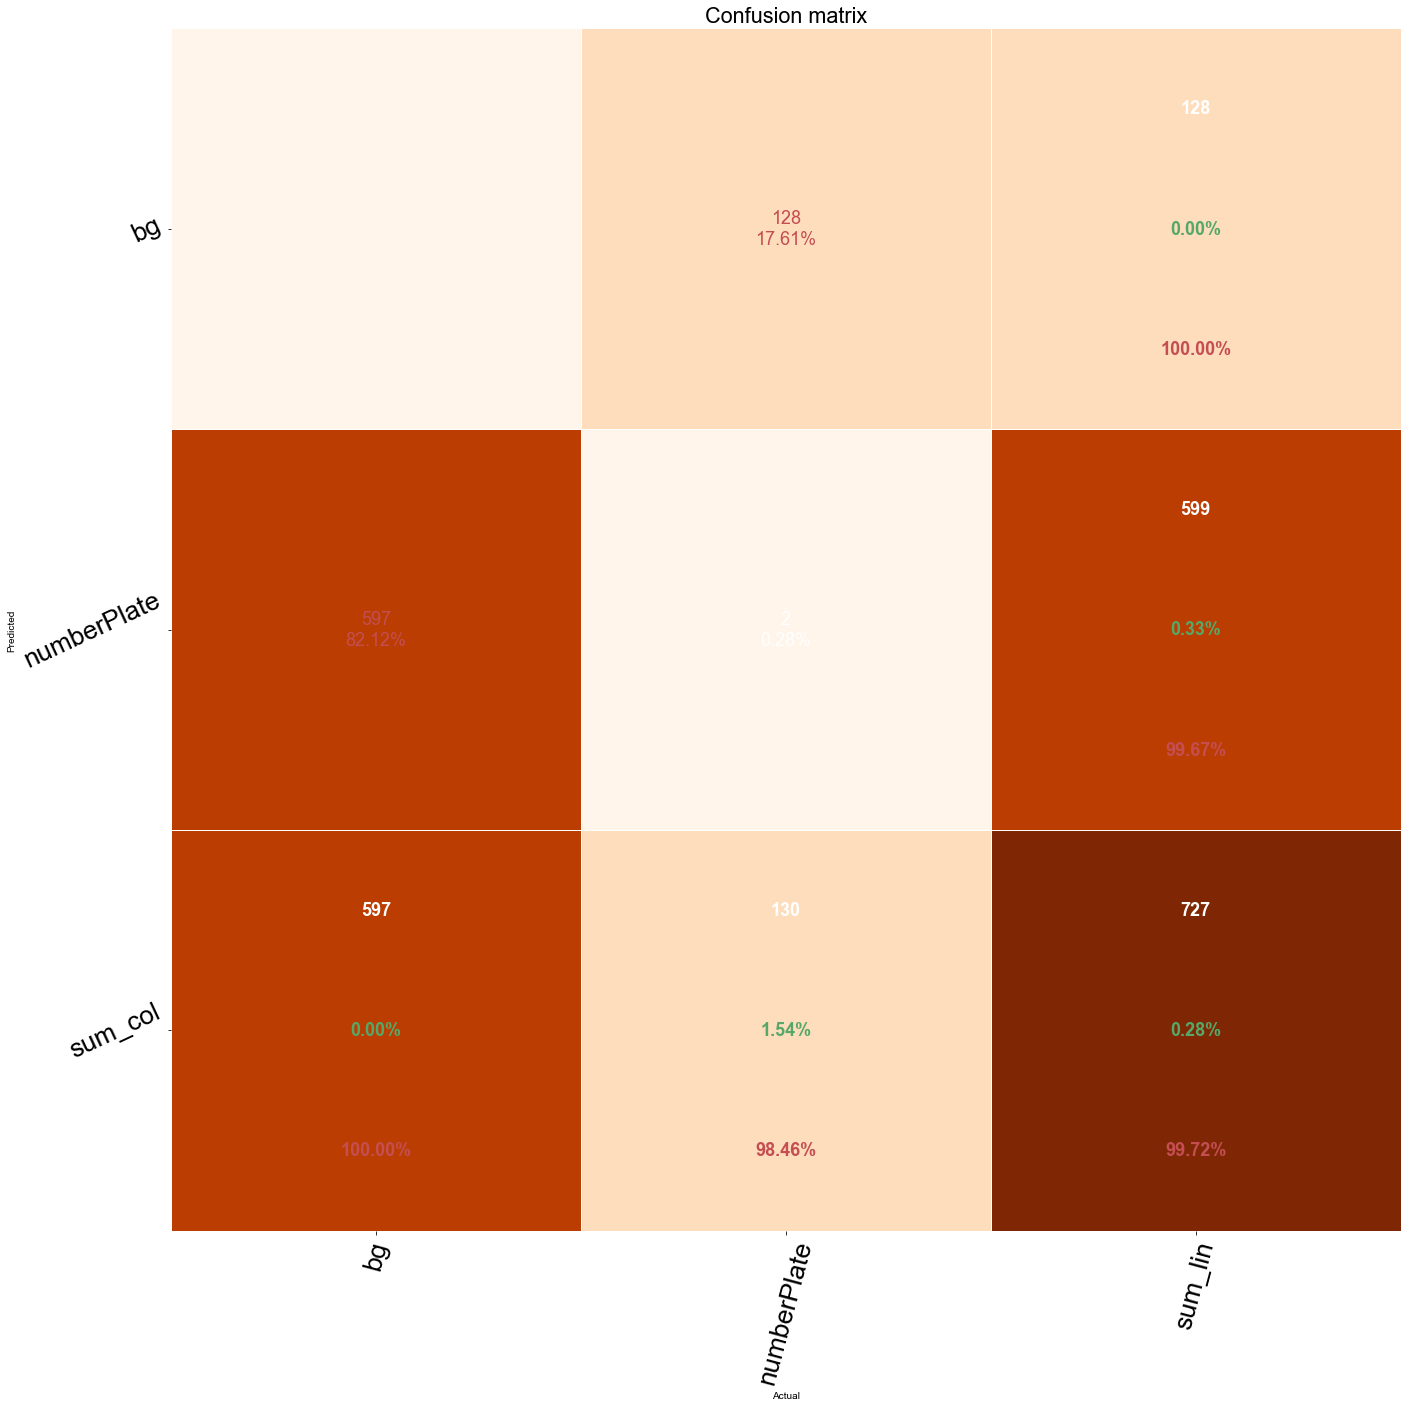

In [15]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","numberPlate"] ,fz=18, figsize=(20,20), lw=0.5)

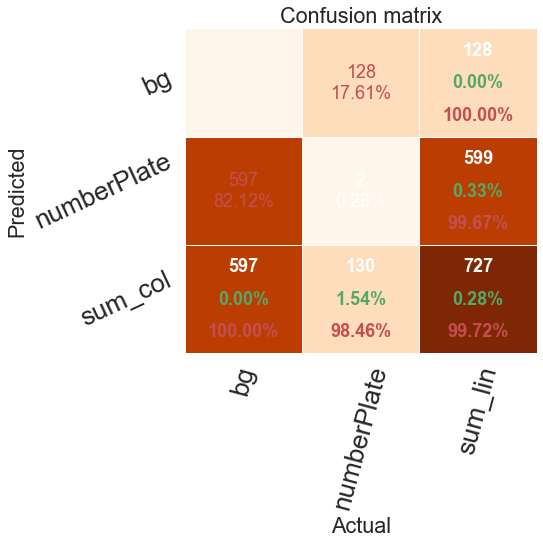

In [16]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","numberPlate"] ,fz=18, figsize=(8,8), lw=0.5)


In [17]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 2]
fp for each class : [128, 597]
fn for each class : [597, 128]

########################

tp for each class : [2]
fp for each class : [597]
fn for each class : [128]


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the list of class names
class_names = ["bg", "numberPlate"]  # Replace with your actual class names

# Calculate the confusion matrix using your existing code
confusion = confusion_matrix(gt_tot, pred_tot, labels=range(len(class_names)))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[  0 597]
 [128   2]]


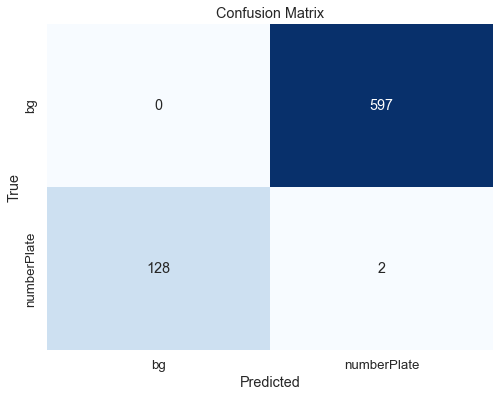

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of class names
class_names = ["bg", "numberPlate"]  # Replace with your actual class names

# Calculate the confusion matrix using your existing code
confusion = confusion_matrix(gt_tot, pred_tot, labels=range(len(class_names)))

# Create a heatmap with colored cells
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


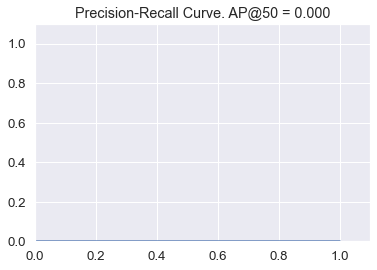

In [21]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# # Draw precision-recall curve  

##### The PR curve is for single detected image 

# calculate the mAP for a batch of validation images

Re-starting from epoch 5
Images: 119
Classes: ['BG', 'numberPlate']
Loading weights  C:\Users\Maneka Wijesundara\Desktop\DLASS005\logs\object20230927T2142\mask_rcnn_object_0005.h5
mAP @ IoU=50:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


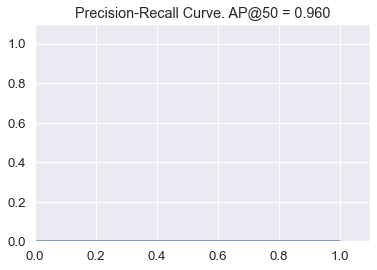

In [22]:
path = os.getcwd()
#model_tar = "nuclei_datasets.tar.gz"
data_path = os.path.join(path + '\Dataset')
model_path = os.path.join(path + '\logs\object20230927T2142')
weights_path = os.path.join(model_path + '\mask_rcnn_object_0005.h5') #My weights file

DEVICE = "/gpu:0" 


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)

    
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

#dataset.load_nucleus(data_path, 'val')
#dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()
    
    
    

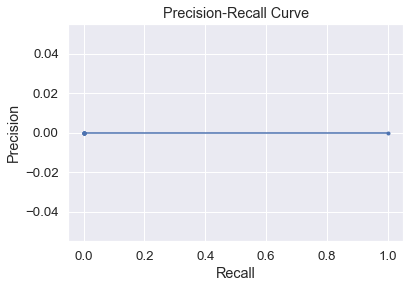

In [23]:
import matplotlib.pyplot as plt

plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


# Load a random image from the images folder and perform prediction

In [ ]:

# IMAGE_DIR = os.path.join(ROOT_DIR, "test_images")

# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'Hard_hat', 'Safety_vest']

# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])

Processing 1 images
image                    shape: (300, 467, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


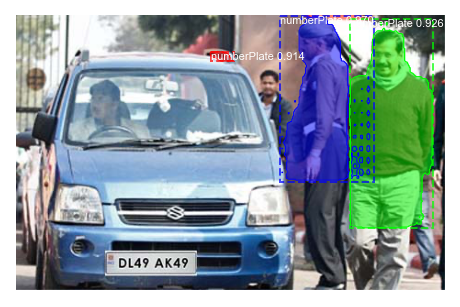

In [24]:
import os
import random
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from mrcnn import utils
from mrcnn import visualize

# Path to the folder containing your test images
test_image_folder = 'C:\\Users\\Maneka Wijesundara\\Desktop\\DLASS005\\test_images\\'

# Get a list of image file names in the folder
image_files = os.listdir(test_image_folder)

# Choose a random image file from the list
random_image_file = random.choice(image_files)

# Load the chosen image
image_path = os.path.join(test_image_folder, random_image_file)

# Load and preprocess the image
image = skimage.io.imread(image_path)
if image.shape[-1] == 4:
    # Convert RGBA to RGB by removing the alpha channel
    image = image[:, :, :3]

# Run object detection on the image
results = model.detect([image], verbose=1)
r = results[0]  # Assuming there's only one image in the results

# Display the original image with predicted masks, bounding boxes, and class labels
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

# Show the image
plt.show()
